1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [3]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO


df = pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col = 0)
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [4]:
df['default'] = df['default'].replace("No",0)
df['default'] = df['default'].replace("Yes",1)
df['student'] = df['student'].replace("No",0)
df['student'] = df['student'].replace("Yes",1)
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

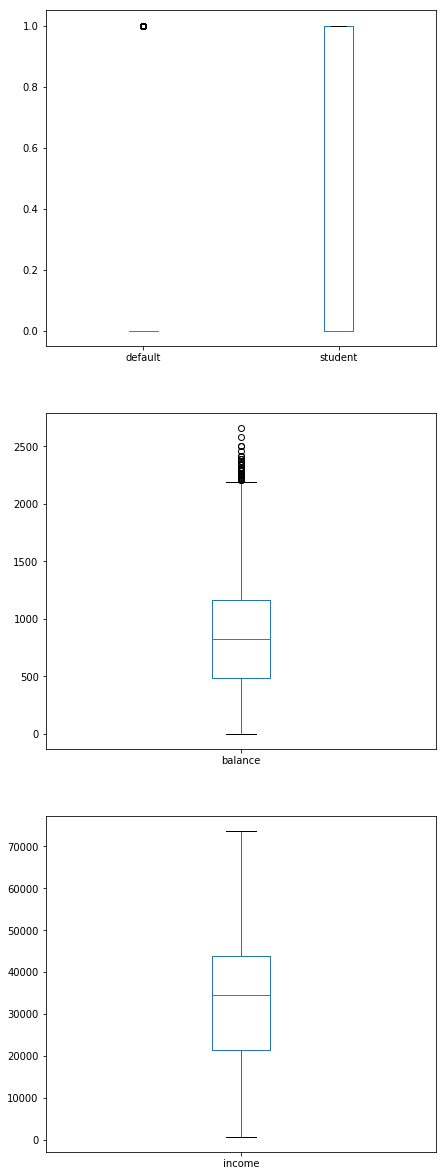

In [5]:
fig, axis = plt.subplots(3,1,figsize=(7,21))
dfvar = df.drop(['balance','income'],axis=1)
dfvar.plot.box(ax=axis[0])

df['balance'].plot.box(ax=axis[1])

df['income'].plot.box(ax=axis[2])
plt.show()

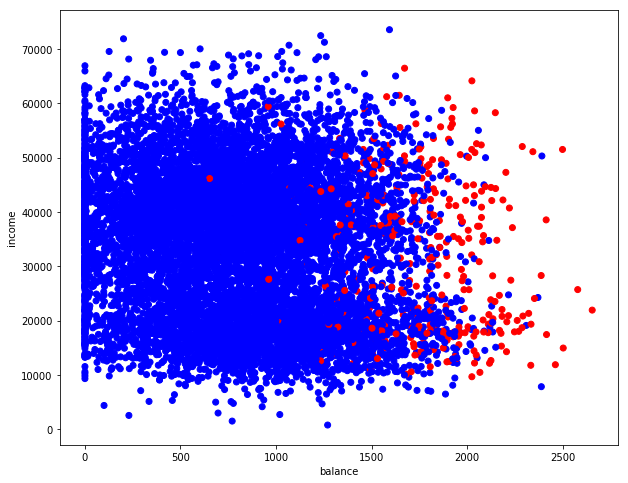

In [6]:
fig, axis = plt.subplots(figsize=(10,8))
colors = df ["default"]
colors = colors.replace(1,"r").replace(0,"b")
plt.scatter(df['balance'],df['income'],c = colors)
plt.xlabel("balance")
plt.ylabel("income")
plt.show()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


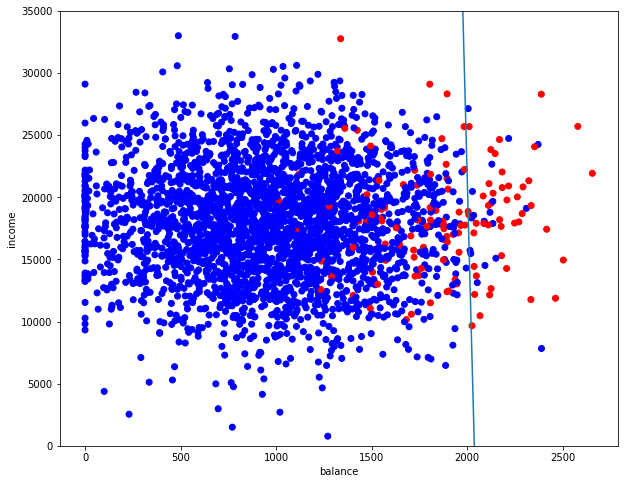

In [7]:
fig, axis = plt.subplots(figsize=(10,8))

dfwos = df[df['student'] == 1]
X = dfwos[['balance','income']]
Y = dfwos[['default']]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 500)

model = LogisticRegression(penalty = "l1")
fit = model.fit(X_train,y_train)

colors= dfwos["default"]
colors = colors.replace(1,"r").replace(0,"b")
plt.scatter(dfwos['balance'],dfwos['income'],c = colors)
plt.xlabel("balance")
plt.ylabel("income")

b = fit.intercept_
coef = fit.coef_[0]

x = np.arange(0,2600,1)
y = (b+coef[0]*x)/(-coef[1])
plt.plot(x,y)
plt.ylim(0,35000)
plt.show()

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


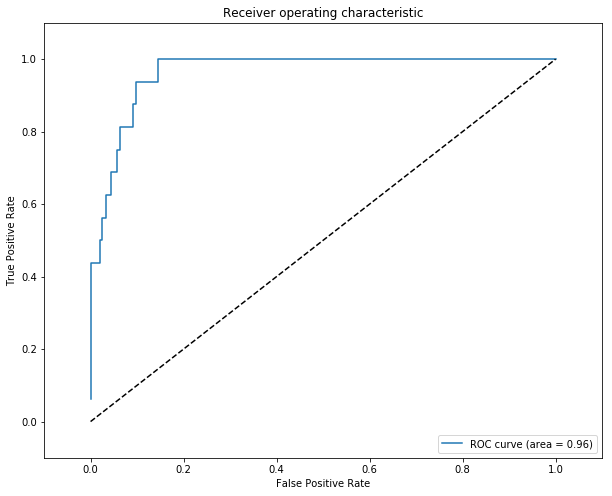

In [8]:
fig, axis = plt.subplots(figsize=(10,8))
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)

    classifier = clf_class(**kwargs)
    probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, thresholds

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
def generate_ROCplot(fpr,tpr,label,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr,label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
# Plots ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

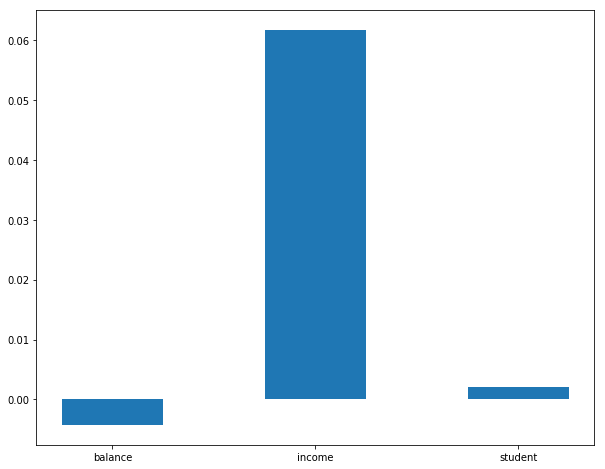

The coefficients: [-0.00427     0.06172524  0.00212686].


In [9]:
X = df[["student","balance","income"]]
Y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size = 0.2,random_state = 50)

alphas = np.logspace(-6, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

best_alpha = alphas[np.argmax(score)]

clf = Ridge(alpha = best_alpha)
clf.fit(X_train, y_train)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
plt.show()
print ('The coefficients: {0}.'.format(clf.coef_))

model = LogisticRegression(penalty='l1', C= best_alpha)
regr = model.fit(X_train, y_train)

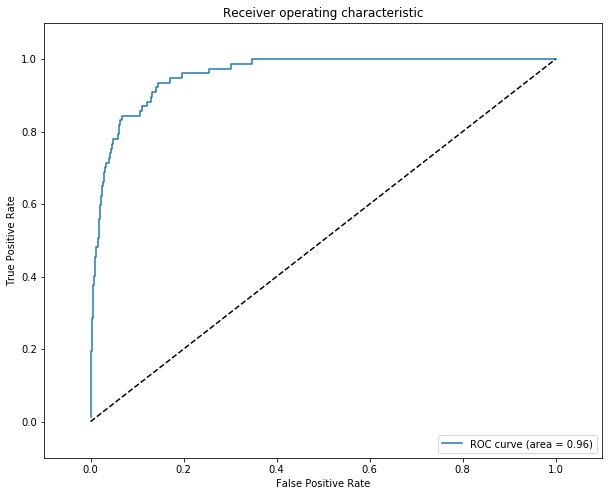

The performance does not improve so much.


In [10]:
fig, axis = plt.subplots(figsize=(10,8))
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print ('The performance does not improve so much.')

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [11]:
scores = cross_val_score(regr, X_train, y_train, cv=10)
print (scores)
print ('\nAs the result of 10-fold cross validation shows the model is robust')

[ 0.96754057  0.96754057  0.96754057  0.96754057  0.9675      0.9675
  0.96871089  0.96871089  0.96871089  0.96871089]

As the result of 10-fold cross validation shows the model is robust


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

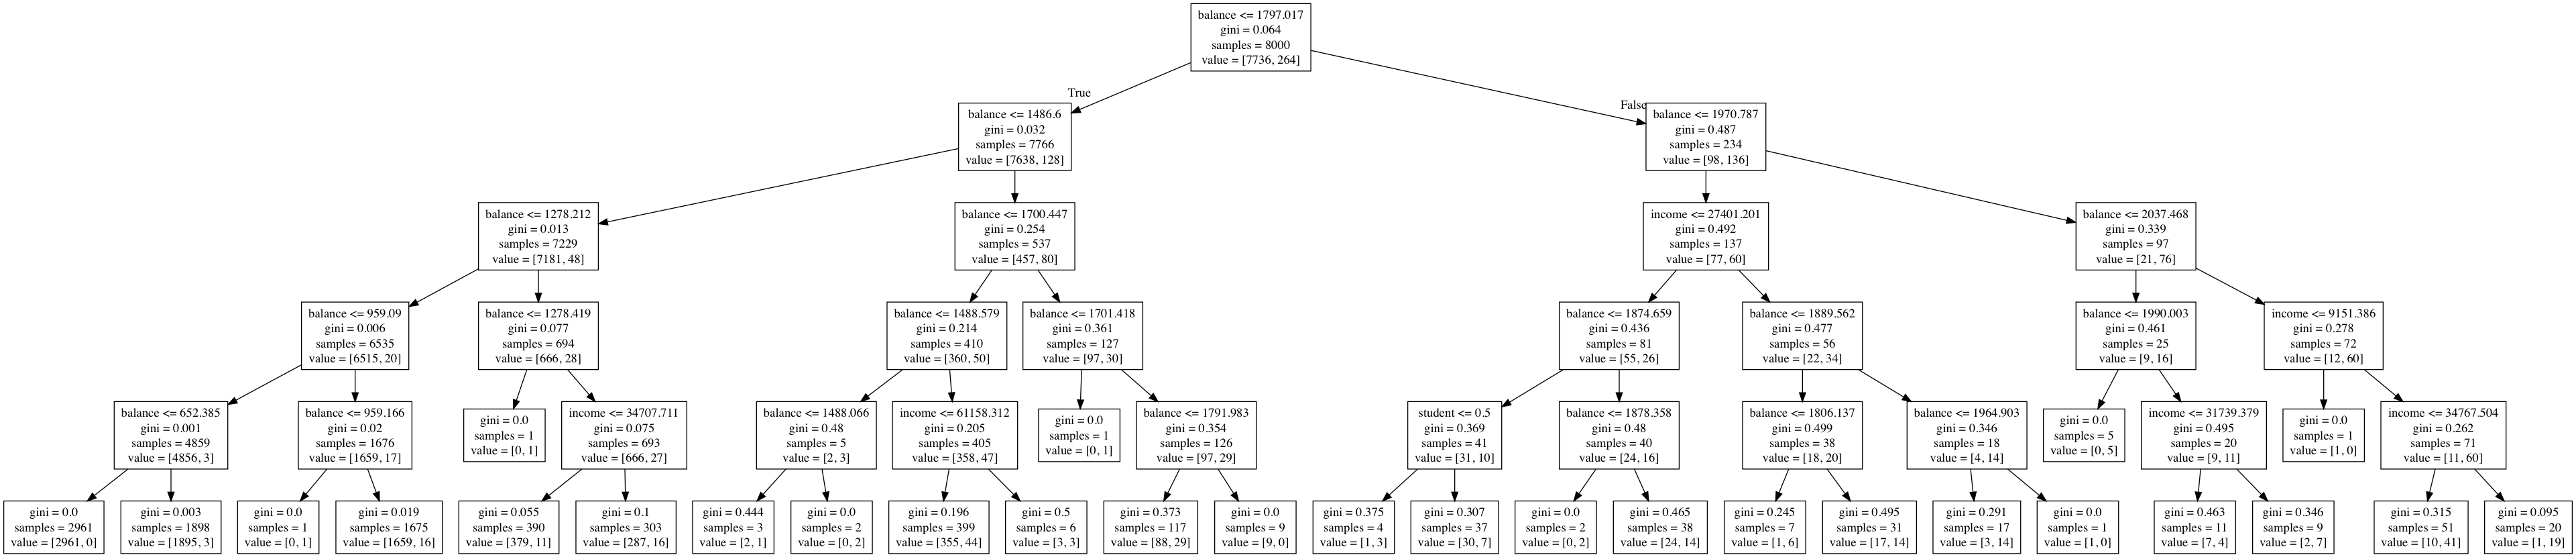

In [12]:
X = df[['student','balance','income']]
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)

dot_data = StringIO()  
export_graphviz(clf, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Depth: 5.


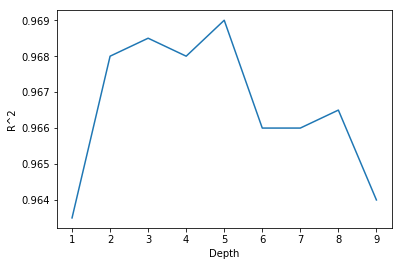

In [13]:
train_errors = []
test_errors = []
scores = []
depths = range(1,10)
for n in depths:
    dt = DecisionTreeClassifier(max_depth=n)
    dt.fit(X_train, y_train)
    train_errors.append(dt.score(X_train,y_train))
    scores.append(dt.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]
print("Optimal Depth: {0}.".format(n_opt))
plt.show()

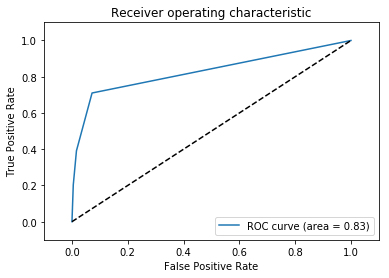

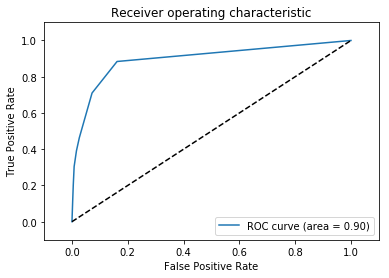

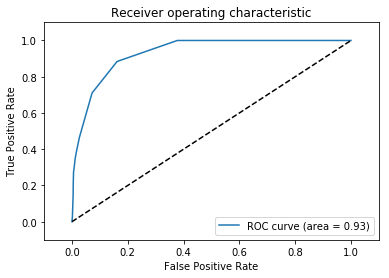

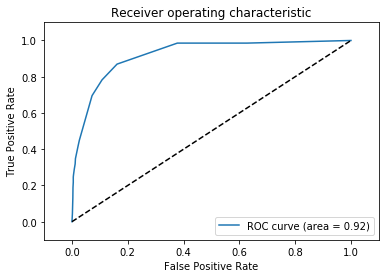

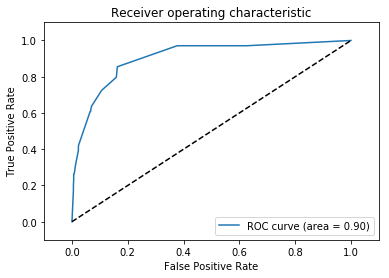

According to ROC curve, the optimal depth is 4.


In [15]:
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 2)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 3)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

print('According to ROC curve, the optimal depth is 4.')